In [1]:
# best 3 solutions based on EXP1 in turns of f1 micro is:
# XGBcls: RoadNet+Social type, 0.6561797753
# BAGcls: RoadNet+Social type, 0.6539325843
# RFreg: RoadNet+Social total, 0.6494382022
# with ~2014, min-max, no feature selection

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
%matplotlib inline


In [3]:
def train_test_idx(seed):
    idx_fn = 'experiment_1001/exp1/seed_%d/indices.txt' % seed
    with open(idx_fn) as f:
        lines = f.readlines()
        train_idx = lines[0].strip().split('\t')[1].split(',')
        train_idx = [int(x) for x in train_idx]
        test_idx = lines[1].strip().split('\t')[1].split(',')
        test_idx = [int(x) for x in test_idx]
    return train_idx, test_idx

In [4]:
seeds = [0, 100, 972, 5258, 7821, 40918, 57852, 168352, 291592, 789729423]
combo = [('NO_TOTAL', 'XGBcls'), ('NO_TOTAL', 'BAGcls'), ('TOTAL', 'RFreg')]

In [5]:
import glob

In [6]:
import os

In [7]:
imps = defaultdict(list)
cfsns = defaultdict(list)

for seed in seeds:
    train_idx, test_idx = train_test_idx(seed)
    print('======', seed, len(test_idx))
    exp_path = 'experiment_1001/exp1/seed_%d' % seed
    for total_or_not, name in combo:
        exp_param_path = '%s/%s' % (exp_path, 'RoadNet+Segment#%s#~2014#min-max#None' % total_or_not)
        try:
            imp = pd.read_csv('%s/imp_%s.csv' %(exp_param_path, name), index_col=0)
            imp.columns = ['label', 'importance_%d' % seed]
            imps[name].append(imp)
        except FileNotFoundError:
            print(name, 'no feature importance')
            
        cfsn = pd.read_csv('%s/cfsn_%s.csv' %(exp_param_path, name), header=[0,1], index_col=[0,1])
        cfsns[name].append(cfsn)
#     break

====== 0 89
BAGcls no feature importance
====== 100 89
BAGcls no feature importance
====== 972 89
BAGcls no feature importance
====== 5258 89
BAGcls no feature importance
====== 7821 89
BAGcls no feature importance
====== 40918 89
BAGcls no feature importance
====== 57852 89
BAGcls no feature importance
====== 168352 89
BAGcls no feature importance
====== 291592 89
BAGcls no feature importance
====== 789729423 89
BAGcls no feature importance


# confusion matrix

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
def save_heatmap(df, fn):
    sns.set(font_scale=2)
    ax = sns.heatmap(df, annot=True, cmap='Greens', annot_kws={"size": 23})
    ax.set_xlabel('')
    ax.set_ylabel('')
    fig = ax.get_figure()
    fig.set_size_inches(10,8)
    fig.savefig('%s.eps' % fn, format='eps', bbox_inches='tight', pad_inches=0.05)
    fig.savefig('%s.png' % fn, format='png', bbox_inches='tight', pad_inches=0.05)
#     plt.show()
    plt.close()

In [65]:
for total_or_not, name in combo:
    total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
    cfsn = sum(cfsns[name])/len(cfsns[name])
    cfsn.index = pd.MultiIndex.from_tuples([('true', x[1]) for x in cfsn.index])    
    fn = 'deliverables/experiment_1001/EXP2 average_confusion_matrix_%s_%s' % (name, total_or_type)
    print(fn)
#     cfsn.to_csv('deliverables/experiment_1001/EXP2 average_confusion_matrix_%s_%s.csv' % (name, total_or_type))
    save_heatmap(cfsn, fn)
    
    cfsn_pcnt_per_row = cfsn.apply(lambda x: x / x.sum(), axis=1)
    fn = 'deliverables/experiment_1001/EXP2 average_confusion_matrix_as_pcnt_per_row_%s_%s' % (name, total_or_type)
#     cfsn_pcnt_per_row.to_csv('deliverables/experiment_1001/EXP2 average_confusion_matrix_as_pcnt_per_row_%s_%s.csv' % (name, total_or_type))
    save_heatmap(cfsn_pcnt_per_row, fn)
#     break

deliverables/experiment_1001/EXP2 average_confusion_matrix_XGBcls_type
deliverables/experiment_1001/EXP2 average_confusion_matrix_BAGcls_type
deliverables/experiment_1001/EXP2 average_confusion_matrix_RFreg_total


In [22]:
def cal_neighbor_miss_pcnt(cfsn):
    non_dia = pd.DataFrame(np.where(np.eye(np.min(cfsn.shape)), np.nan, cfsn.values), cfsn.index, cfsn.columns)
    sum_missed_classified = non_dia.sum().sum()

    sum_next_class = 0
    sum_prev_class = 0
    for i in range(cfsn.shape[0]):
        print(i, end=' ')
        if i>0:
            prev_class = cfsn.iloc[i, i-1]
            sum_prev_class+=prev_class
            print('prev', prev_class,end=' ')
        if i+1<cfsn.shape[0]:
            next_class = cfsn.iloc[i, i+1]
            sum_next_class+=next_class
            print('next', next_class,end=' ')
        print()
    print(sum_prev_class, sum_next_class)
    print(
          'both_way', (sum_prev_class+sum_next_class)/sum_missed_classified,'\n',
          'more_dangerous', sum_prev_class/sum_missed_classified, '\n',
          'safer', sum_next_class/sum_missed_classified, '\n',)

In [23]:
from IPython.display import display

In [24]:
for total_or_not, name in combo:
    print(name)
    total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
    cfsn = pd.read_csv('deliverables/experiment_1001/EXP2 average_confusion_matrix_%s_%s.csv' % (name, total_or_type), index_col=[0,1], header=[0,1])
    display(cfsn)
    cal_neighbor_miss_pcnt(cfsn)

XGBcls


pred                      
          1    2     3     4    5
True 1  0.4  1.0   0.9   0.0  0.0
     2  0.6  3.1   6.9   2.2  0.0
     3  0.0  1.8  32.1   6.7  0.0
     4  0.0  0.4   9.0  22.5  0.0
     5  0.0  0.2   0.4   0.5  0.3

0 next 1.0 
1 prev 0.6 next 6.9 
2 prev 1.8 next 6.7 
3 prev 9.0 next 0.0 
4 prev 0.5 
11.9 14.6
both_way 0.866013071895 
 more_dangerous 0.388888888889 
 safer 0.477124183007 

BAGcls


pred                      
          1    2     3     4    5
True 1  0.2  1.0   1.1   0.0  0.0
     2  0.3  2.8   7.9   1.8  0.0
     3  0.0  1.0  32.9   6.7  0.0
     4  0.0  0.0   9.9  22.0  0.0
     5  0.0  0.1   0.9   0.1  0.3

0 next 1.0 
1 prev 0.3 next 7.9 
2 prev 1.0 next 6.7 
3 prev 9.9 next 0.0 
4 prev 0.1 
11.3 15.6
both_way 0.873376623377 
 more_dangerous 0.366883116883 
 safer 0.506493506494 

RFreg


pred                      
          1    2     3     4    5
True 1  0.0  1.4   0.9   0.0  0.0
     2  0.1  2.8   9.2   0.7  0.0
     3  0.0  0.4  37.5   2.7  0.0
     4  0.0  0.1  14.3  17.5  0.0
     5  0.0  0.0   1.0   0.4  0.0

0 next 1.4 
1 prev 0.1 next 9.2 
2 prev 0.4 next 2.7 
3 prev 14.3 next 0.0 
4 prev 0.4 
15.2 13.3
both_way 0.913461538462 
 more_dangerous 0.487179487179 
 safer 0.426282051282 



In [9]:
def plot_imp(list_imp, name, total_or_type, top=10):
    imp = pd.DataFrame(columns=['label'])
    for df in list_imp:
        imp = imp.merge(df, on='label', how='outer')

    imp = imp.set_index('label')
    means = imp.mean(axis=1)
    stds = imp.std(axis=1)
    means_to_plot = means.sort_values(ascending=False).head(top)
    index_to_plot = means_to_plot.index
    stds_to_plot = stds.loc[index_to_plot]
    ax = means_to_plot.sort_values().plot(kind='barh', xerr=stds_to_plot, figsize=(10,7))
    ax.set_xlabel('importance with std as errorbar')
    ax.set_ylabel('feature')
    fig = ax.get_figure()
#     fig.savefig(u'deliverables/experiment_1001/EXP2 feature importance - %s_RoadNet+social_%s.png' % (name, total_or_type), format='png', bbox_inches='tight', pad_inches=0)
    

In [10]:
total_or_not, name = combo[0]
total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
# plot_imp(imps[name], name, total_or_type, 10)
imp = pd.DataFrame(columns=['label'])
for df in imps[name]:
    imp = imp.merge(df, on='label', how='outer')

In [11]:

imp.mean(axis=1).head(10)

0    0.037010
1    0.022104
2    0.022485
3    0.018013
4    0.020020
5    0.017915
6    0.018829
7    0.016944
8    0.018117
9    0.013864
dtype: float64

RFreg


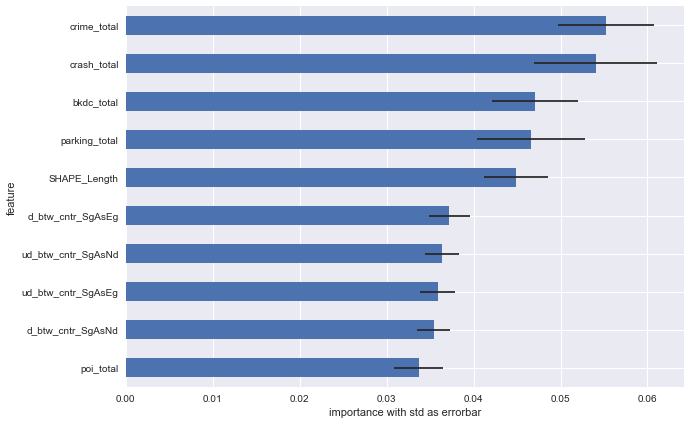

In [12]:
total_or_not, name = combo[2]
print(name)
total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
plot_imp(imps[name], name, total_or_type, 10)

XGBcls


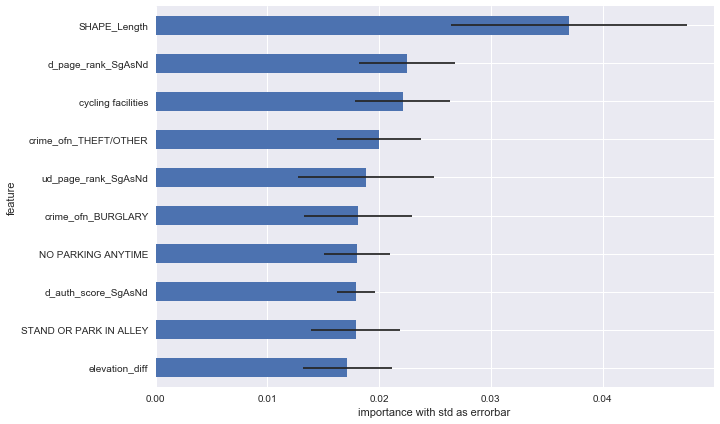

In [13]:
total_or_not, name = combo[0]
print(name)
total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
plot_imp(imps[name], name, total_or_type, 10)

In [15]:
list_imp=imps[name]

In [18]:
imp = pd.DataFrame(columns=['label'])
for df in list_imp:
    imp = imp.merge(df, on='label', how='outer')

imp = imp.set_index('label')
means = imp.mean(axis=1)
stds = imp.std(axis=1)
means_to_plot = means.sort_values(ascending=False).head(10)

In [20]:
means_to_plot.index.tolist()

['SHAPE_Length',
 'd_page_rank_SgAsNd',
 'cycling facilities',
 'crime_ofn_THEFT/OTHER',
 'ud_page_rank_SgAsNd',
 'crime_ofn_BURGLARY',
 'NO PARKING ANYTIME',
 'd_auth_score_SgAsNd',
 'STAND OR PARK IN ALLEY',
 'elevation_diff']